In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./..")

In [3]:
import numpy as np
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision
import torch.nn as nn
from torch import optim
#
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm
#

from misc.plot_utils import plot_mat, imshow
from effcn.layers import FCCaps, FCCapsWOBias, Squash
from effcn.utils import count_parameters
from effcn.functions import margin_loss
from datasets import AffNIST
#
from perceiver_pytorch import Perceiver

In [4]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)

In [5]:
transform_train = None
transform_valid = None # converts [0,255] to [0,1] by dividing through 255

p_data = '/home/matthias/projects/EfficientCN/data'

ds_mnist_train = AffNIST(p_root=p_data, split="mnist_train", download=True, transform=transform_train, target_transform=None)
ds_mnist_valid = AffNIST(p_root=p_data, split="mnist_valid", download=True, transform=transform_valid, target_transform=None)
ds_affnist_valid = AffNIST(p_root=p_data, split="affnist_valid", download=True, transform=transform_valid, target_transform=None)

In [6]:
bs = 512
dl_mnist_train = torch.utils.data.DataLoader(
    ds_mnist_train, 
    batch_size=bs, 
    shuffle=True,
    pin_memory=True,
    num_workers=4)
dl_mnist_valid= torch.utils.data.DataLoader(
    ds_mnist_valid, 
    batch_size=bs, 
    shuffle=True, 
    pin_memory=True,
    num_workers=4)
dl_affnist_valid= torch.utils.data.DataLoader(
    ds_affnist_valid, 
    batch_size=bs, 
    shuffle=True, 
    pin_memory=True,
    num_workers=4)

In [7]:
x, _ = next(iter(dl_mnist_train))
x_vis_train = x[:32]

x, _ = next(iter(dl_mnist_valid))
x_vis_mnist_valid = x[:32]

x, _ = next(iter(dl_affnist_valid))
x_vis_affnist_valid = x[:32]

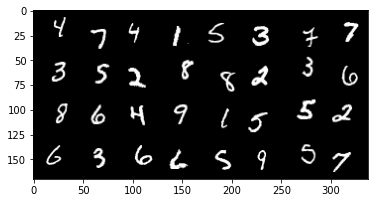

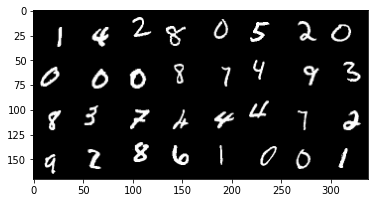

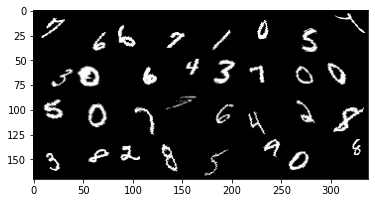

In [8]:
plt.imshow(torchvision.utils.make_grid(x_vis_train).permute(1,2,0))
plt.show()
#
plt.imshow(torchvision.utils.make_grid(x_vis_mnist_valid).permute(1,2,0))
plt.show()
#
plt.imshow(torchvision.utils.make_grid(x_vis_affnist_valid).permute(1,2,0))
plt.show()

In [28]:
model = Perceiver(
    input_channels = 1,          # number of channels for each token of the input
    input_axis = 2,              # number of axis for input data (2 for images, 3 for video)
    num_freq_bands = 1,          # number of freq bands, with original value (2 * K + 1)
    max_freq = 10.,              # maximum frequency, hyperparameter depending on how fine the data is
    depth = 1,                   # depth of net. The shape of the final attention mechanism will be:
                                 #   depth * (cross attention -> self_per_cross_attn * self attention)
    num_latents = 64,            # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 128,             # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 1,            # number of heads for latent self attention, 8
    cross_dim_head = 16,          # number of dimensions per cross attention head
    latent_dim_head = 256,        # number of dimensions per latent self attention head
    num_classes = 10,           # output number of classes
    attn_dropout = 0.,
    ff_dropout = 0.,
    weight_tie_layers = False,   # whether to weight tie layers (optional, as indicated in the diagram)
    fourier_encode_data = True,  # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
    self_per_cross_attn = 1      # number of self attention blocks per cross attention
)
model = model.to(device)
print(count_parameters(model))

541944


In [29]:
model(torch.rand(1, 40, 40, 1).to(device))

tensor([[ 0.0077,  0.2132,  0.4226,  1.0483,  0.0257,  0.8409,  0.5046,  1.2567,
          0.3447, -0.0947]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [30]:
model.layers[0][0]

PreNorm(
  (fn): Attention(
    (to_q): Linear(in_features=128, out_features=16, bias=False)
    (to_kv): Linear(in_features=7, out_features=32, bias=False)
    (dropout): Dropout(p=0.0, inplace=False)
    (to_out): Linear(in_features=16, out_features=128, bias=True)
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (norm_context): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
)

In [31]:
model

Perceiver(
  (layers): ModuleList(
    (0): ModuleList(
      (0): PreNorm(
        (fn): Attention(
          (to_q): Linear(in_features=128, out_features=16, bias=False)
          (to_kv): Linear(in_features=7, out_features=32, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
          (to_out): Linear(in_features=16, out_features=128, bias=True)
        )
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm_context): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
      )
      (1): PreNorm(
        (fn): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=128, out_features=1024, bias=True)
            (1): GEGLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
            (3): Dropout(p=0.0, inplace=False)
          )
        )
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (2): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
          

In [26]:
class GEGLU(nn.Module):

    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)

In [32]:
x, gates = torch.rand(1,128).chunk(2, dim=-1)

In [34]:
gates.shape


torch.Size([1, 64])

In [27]:
x = torch.rand(1, 128)
y = GEGLU()(x)
y.shape

torch.Size([1, 64])

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay=2e-5)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 51
#
for epoch_idx in range(num_epochs):
    # ####################
    # TRAIN
    # ####################
    model.train()
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_mnist_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    
    for x,y_true in pbar:
        x = x.to(device)
        y_true = y_true.to(device)
        optimizer.zero_grad()
        
        logits = model.forward(x.permute(0,2,3,1))
        loss = criterion(logits, y_true)
        loss.backward()
        
        optimizer.step()
        
        
        y_pred = torch.argmax(logits, dim=1)
        acc = (y_true == y_pred).sum() / y_true.shape[0]
        
        pbar.set_postfix(
                {'loss': loss.item(),
                 'acc': acc.item()
                 }
        )
    
    lr_scheduler.step()
    #
    # ####################
    # VALID
    # ####################
    if epoch_idx % 5 != 0:
        continue
    
    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_mnist_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            logits = model.forward(x.permute(0,2,3,1))
            y_pred = torch.argmax(logits, dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   mnist acc_valid: {:.3f}".format(total_correct / total))

    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_affnist_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            logits = model.forward(x.permute(0,2,3,1))
            y_pred = torch.argmax(logits, dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   affnist acc_valid: {:.3f}".format(total_correct / total))